In [1]:
import os
import os.path as osp
import pickle
import json
import collections as C
import itertools as I
import random
import regex as re
import multiprocessing as mp
import dataclasses as D
from typing import List, Optional, Dict, Tuple

import networkx as nx
from tqdm import tqdm
from dacite import from_dict
from loguru import logger

from common.constants import BANNED_TOKENS_IN_ANSWER_TYPE, BANNED_TOKENS_IN_SOLVING_STATE, CORE_OPTIONS, FPS_GLOBAL_SETTING
from common.pantograph.dataclasses import SolutionAutoformalizationResult, Goal, GoalState, FormalProblem, Variable, CompilationUnit, TacticDraft
from common.pantograph.server import Server, TacticFailure
from common.pantograph.solving_server import PersistentPropSolvingServer
from common.utils import remove_comments, normalize_spaces, format_forward_solution_step_prompt, replace_span, chunk_list, parse_idents, remove_min_whitespace

def normalize_draft(s: str) -> str:
    s_normalized = re.sub(
        r':=\s*sorry', r':= sorry',
            re.sub(
        r':=\s*by\s+sorry', r':= sorry',
        remove_comments(s)
    )).strip()
    return '\n'.join(l for l in s_normalized.splitlines() if l.strip() != '')


FPS_GLOBAL_SETTING['TO_SYNC_ENABLED'] = True

In [2]:
def worker_cycle1(args):
    path = args
    with open(osp.join(path), 'rb') as f:
        _, _, _, _, data = pickle.load(f)
    return data


In [3]:
# Cycle 1
data_root = '/sfs/liuqi/data/AI-MO/NuminaMath-1.5/cycle2/dones_all'

ps = [osp.join(data_root, p) for p in os.listdir(data_root) if p.startswith('processed_') and p.endswith('.pkl')]
print(len(ps))

428


In [4]:
# with mp.Pool(processes=128) as pool:
#     results = pool.map(worker_cycle1, ps)
results = [worker_cycle1(ps[0])]

In [5]:
results = list(I.chain(*results))

In [6]:
len(results)

874

In [7]:
results[0].__dict__.keys()

dict_keys(['informal_problem', 'informal_answer', 'informal_solution', 'header', 'formal_statement', 'intros', 'formal_answer', 'formal_answer_type', 'outros', 'formal_solution_draft', 'formal_proofs', 'metainfo', 'success', 'token_usages'])

In [8]:
server = PersistentPropSolvingServer(
    imports=["Mathlib", "Aesop"],
    project_path='/home/ma-user/workspace/fps_pantograph/formal_problem_solving/data/MiniF2F',
    timeout=120,
    _sync_init=False,
)

server.set_tag(f'test')

## Sample Parse

In [9]:
sample = results[1]

In [10]:
solution_transitions = sample.metainfo['solution_state_transition'][:]
formal_proofs = sample.formal_proofs[:]
pruning_history = []

problem_var_names = set([v.name for v in sample.intros if v.name is not None] + ['answer'] + [v.name for v in sample.outros if v.name is not None])

In [11]:
print(sample.formal_statement)
print(problem_var_names)

example
(answer : ℝ)
  (angle_Y : ℝ) (angle_Z : ℝ) (angle_X : ℝ)
  (h₀ : angle_Y = 15) -- The measure of angle $Y$ is $15^\circ$
  (h₁ : angle_Z = 3 * angle_Y) -- The measure of angle $Z$ is three times the measure of angle $Y$
  (h₂ : angle_X + angle_Y + angle_Z = 180) -- The sum of the angles in a triangle is $180^\circ$
  (h_answer : angle_X = answer) -- What is the measure of angle $X$?
: -- the answer is 120^\circ
answer = 120
:= sorry
{'angle_X', 'h₁', 'h₂', 'answer', 'angle_Y', 'angle_Z', 'h_answer', 'h₀'}


In [12]:
@D.dataclass(frozen=True)
class ProblemGenerationStep:
    step_draft: str
    proof: Optional[Tuple[str]]
    new_contexts: Optional[Tuple[Variable]] # Newly introduced contexts (excluding removed old contexts, including newly-modified contexts)

    def __post__init__(self):
        self.proof = tuple(self.proof)
        self.new_contexts = tuple(self.new_contexts)

    @property
    def is_introducing(self):
        return self.proof is None
    
    @property
    def is_deducing(self):
        return not self.is_introducing and not self.is_submitting

    @property
    def is_submitting(self):
        return self.new_contexts is None
    
    @property
    def step(self):
        if self.proof is None:
            return self.step_draft
        else:
            normalized_step_draft = normalize_draft(self.step_draft)
            matches = list(re.finditer(':= sorry', normalized_step_draft))
            assert len(matches) == len(self.proof)
            for (m, p) in reversed(list(zip(matches, self.proof))):
                normalized_step_draft = replace_span(m.span(), ':= by {\n' + p + '\n}', normalized_step_draft)
            return normalized_step_draft

# @D.dataclass(frozen=True)
# class ProblemGenerationData:
#     G: nx.DiGraph
    # node: ProblemGenerationStep, edge: dependencies


## Dependency Analysis

In [13]:
state, action = solution_transitions[-1]
action = remove_comments(action).strip()
assert action.startswith('exact ')
submission_name = action[len('exact '):]
print(submission_name)

h_answer


In [14]:
forward_state = await server.init_forward_reasoning_state_async(sample)
assert len(forward_state.goals) == 1


2025-07-28 20:19:14.582 | DEBUG    | common.pantograph.server:check_restart_async:565 - PersistentServer(test/tactic_server): Restarting...


In [15]:
assert all('✝' not in v.name for v in forward_state.goals[0].variables)

In [16]:
solution_draft_normalized = normalize_draft('\n'.join([s[1] for s in solution_transitions]))
matches = list(re.finditer(':= sorry', solution_draft_normalized))
assert len(matches) == len(formal_proofs), f'`len(matches) == len(formal_proofs)` failed because {len(matches)} != {len(formal_proofs)}, unable to prune'

In [17]:
dependency_graph = nx.DiGraph()
hard_dependencies_global = []
parsed_steps = [
    ProblemGenerationStep(
        step_draft=f'have {v.name} : {v.t} := sorry' if v.v is None else f'let {v.name} : {v.t} := {v.v}',
        proof=None,
        new_contexts=tuple([v])
    ) for v in forward_state.goals[0].variables
]
fvarid_to_istep = {
    v.raw_name : i for (i, v) in enumerate(forward_state.goals[0].variables)
}
i_proof = 0


# Add dependencies between current `parsed_steps` (hypotheses)
dependency_graph.add_nodes_from(parsed_steps)
for (i, v) in enumerate(parsed_steps):
    idents = parse_idents(v.new_contexts[0].t)
    for u in parsed_steps[:i]:
        if u.new_contexts[0].name in idents:
            # edge (u, v): v depends on u
            dependency_graph.add_edge(u, v)

In [18]:
for i_step, (_, draft_step) in enumerate(solution_transitions[:-1]):
    # 1. Execute current step
    normalized_draft_step = normalize_draft(draft_step)
    if 'sorry' in parse_idents(normalized_draft_step):
        new_forward_state = await server.tactic_server.goal_tactic_async(forward_state, 0, TacticDraft('by\n' + normalized_draft_step + '\nsorry'))
    else:
        new_forward_state = await server.tactic_server.goal_tactic_async(forward_state, 0, normalized_draft_step)

    assert new_forward_state.goals[-1].target == 'False'
    n_sorries = len(new_forward_state.goals) - 1
    for p in sample.formal_proofs[i_proof:i_proof+n_sorries]:
        new_forward_state = await server.tactic_server.goal_tactic_async(new_forward_state, 0, '{\n' + '\n'.join([remove_min_whitespace(s[1]) for s in p.proof]) + '\n}')
    
    assert len(new_forward_state.goals) == 1 and new_forward_state.goals[0].target == 'False'
    
    # 2. Analyze state difference
    new_contexts = [
        v for v in new_forward_state.goals[0].variables if
            v.raw_name not in {vv.raw_name for vv in forward_state.goals[0].variables}
            # v not in forward_state.goals[0].variables
    ]
    if len(new_contexts) == 0:
        logger.warning(f'Unused step: {[normalized_draft_step]}')
    for v in new_contexts:
        # assert v.raw_name not in fvarid_to_istep.keys()
        fvarid_to_istep[v.raw_name] = len(parsed_steps) # Maybe override!
    
    # 3.1 Add parsed step
    cur_step = ProblemGenerationStep(
        step_draft=draft_step,
        proof=tuple(['\n'.join([remove_min_whitespace(s[1]) for s in p.proof]) for p in sample.formal_proofs[i_proof:i_proof+n_sorries]]),
        new_contexts=tuple(new_contexts)
    )
    logger.info(f'Step: {cur_step.step}')
    parsed_steps.append(cur_step)
    dependency_graph.add_node(cur_step)
    i_proof += n_sorries
    # 3.2 Coarse-grained dependency
    # - Case 1. types in new_contexts
    # - Case 2. proofs
    
    # 4. (Optional) Validate assumption: forward_state.goals[0].variables is topologically sorted
    tmp_parsing_state = forward_state
    while len(tmp_parsing_state.goals[0].variables) > 0:
        tmp_parsing_state = await server.tactic_server.goal_tactic_async(tmp_parsing_state, 0, f'clear {tmp_parsing_state.goals[0].variables[-1].name}')
    assert str(tmp_parsing_state) == '⊢ False'
    
    # 5. Analyze dependency
    soft_dependencies = set()    # Set of fVarId. Removing which will corrupt other variables
    hard_dependencies = set()    # Set of fVarId. Removing which will make the current step unable to prove
    # Try removing `v` and re-executing cur_step
    # Assumption: tmp_parsing_state.goals[0].variables is topologically sorted
    tmp_parsing_state = forward_state
    
    for v in forward_state.goals[0].variables:  # TODO: Debug, removed 'reversed'
        assert v.raw_name not in soft_dependencies and v.raw_name not in hard_dependencies
        
        # Shall we try clearing steps introducing `v` and all variables dependent on it?
        # No. Because this clearing is in reversed order. If some variable `u` is dependent on `v`
        # - Case 1. `s` does not depend on `u`: `u` is already removed
        # - Case 2. `s` depends on `u`: it does not matter if we still connect `v` with `u`.
        # TODO: Maybe add an extra edge pruning to remove all non-direct dependencies? (i.e. dependencies that can be constructed by transitive dependency)

        # 5.1. Find v
        v_to_remove = [vv for vv in tmp_parsing_state.goals[0].variables if vv.raw_name == v.raw_name]
        assert len(v_to_remove) == 1    # `tmp_parsing_state` is constructed by iteratively removing variables in forward_state, thus must find exactly one
        v_to_remove = v_to_remove[0]
        
        # 5.1. Try removing `v`
        if '✝' not in v.name:
            try:
                new_tmp_parsing_state = await server.tactic_server.goal_tactic_async(tmp_parsing_state, 0, f'clear {v.name}')
            except TacticFailure:
                soft_dependencies.add(v.raw_name)
                logger.info(f'Cannot remove {v} ({[vv.name for vv in parsed_steps[fvarid_to_istep[v.raw_name]].new_contexts]})')
                continue
        else:
            n_inaccessible_after = 0
            for vv in reversed(tmp_parsing_state.goals[0].variables):
                if vv.raw_name == v.raw_name:
                    break
                else:
                    if '✝' in vv.name:
                        n_inaccessible_after += 1
            assert all(vv.name != '_TMP_NAME_TO_REMOVE' for vv in tmp_parsing_state.goals[0].variables)
            new_tmp_parsing_state = await server.tactic_server.goal_tactic_async(tmp_parsing_state, 0, f'rename_i _TMP_NAME_TO_REMOVE' + ' _' * n_inaccessible_after)
            
            all_to_temove = [vv for vv in new_tmp_parsing_state.goals[0].variables if vv.name == '_TMP_NAME_TO_REMOVE']
            assert len(all_to_temove) == 1 and all_to_temove[0].raw_name == v_to_remove.raw_name
            
            try:
                new_tmp_parsing_state = await server.tactic_server.goal_tactic_async(tmp_parsing_state, 0, f'clear _TMP_NAME_TO_REMOVE')
            except TacticFailure:
                soft_dependencies.add(v.raw_name)
                logger.info(f'Cannot remove {v} ({[vv.name for vv in parsed_steps[fvarid_to_istep[v.raw_name]].new_contexts]})')
                continue
        
        # Step 2. Try executing cur_step
        try:
            test_tmp_parsing_state = await server.tactic_server.goal_tactic_async(new_tmp_parsing_state, 0, cur_step.step)
            tmp_parsing_state = new_tmp_parsing_state
        except TacticFailure:
            hard_dependencies.add(v.raw_name)
            hard_dependencies_global.append((parsed_steps[fvarid_to_istep[v.raw_name]], cur_step))
            logger.info(f'{[vv.name for vv in cur_step.new_contexts]} depends on {[vv.name for vv in parsed_steps[fvarid_to_istep[v.raw_name]].new_contexts]}')
            continue
        logger.info(f'Removed {v} ({[vv.name for vv in parsed_steps[fvarid_to_istep[v.raw_name]].new_contexts]})')
    logger.info(f'Final removing state: {test_tmp_parsing_state}')
    # 6. Iteration end
    for d in I.chain(soft_dependencies, hard_dependencies):
        # edge (u, v): v depends on u
        logger.info(f'Adding dependency: {[vv.name for vv in parsed_steps[fvarid_to_istep[d]].new_contexts]} -> {[vv.name for vv in cur_step.new_contexts]}')
        dependency_graph.add_edge(parsed_steps[fvarid_to_istep[d]], cur_step)
    
    forward_state = new_forward_state

assert i_proof == len(formal_proofs)

2025-07-28 20:19:20.656 | INFO     | __main__:<module>:34 - Step: have h_angle_Z : angle_Z = 3 * angle_Y := h₁
2025-07-28 20:19:21.123 | INFO     | __main__:<module>:75 - Cannot remove answer : ℝ (['answer'])
2025-07-28 20:19:21.177 | INFO     | __main__:<module>:75 - Cannot remove angle_Y : ℝ (['angle_Y'])
2025-07-28 20:19:21.231 | INFO     | __main__:<module>:75 - Cannot remove angle_Z : ℝ (['angle_Z'])
2025-07-28 20:19:21.284 | INFO     | __main__:<module>:75 - Cannot remove angle_X : ℝ (['angle_X'])
2025-07-28 20:19:21.396 | INFO     | __main__:<module>:107 - Removed h₀ : angle_Y = 15 (['h₀'])
2025-07-28 20:19:21.503 | INFO     | __main__:<module>:105 - ['h_angle_Z'] depends on ['h₁']
2025-07-28 20:19:21.614 | INFO     | __main__:<module>:107 - Removed h₂ : angle_X + angle_Y + angle_Z = 180 (['h₂'])
2025-07-28 20:19:21.725 | INFO     | __main__:<module>:107 - Removed h_answer : angle_X = answer (['h_answer'])
2025-07-28 20:19:21.726 | INFO     | __main__:<module>:108 - Final removi

In [25]:
assert submission_name in [v.name for v in parsed_steps[-1].new_contexts]

submission_step = ProblemGenerationStep(
    step_draft=f'submit_answer {submission_name}',
    proof=None,
    new_contexts=None
)
dependency_graph.add_node(submission_step)
for s in reversed(parsed_steps):
    if submission_name in [v.name for v in s.new_contexts]:
        dependency_graph.add_edge(s, submission_step)
        break
assert dependency_graph.in_degree(submission_step) == 1
parsed_steps.append(submission_step)

In [26]:
for step in parsed_steps:
    print(normalize_draft(step.step))
    print('\n'.join(v.raw_name + ' ' + str(v) for v in (step.new_contexts or [])))
    print('\n')

have answer : ℝ := sorry
_uniq.327 answer : ℝ


have angle_Y : ℝ := sorry
_uniq.328 angle_Y : ℝ


have angle_Z : ℝ := sorry
_uniq.329 angle_Z : ℝ


have angle_X : ℝ := sorry
_uniq.330 angle_X : ℝ


have h₀ : angle_Y = 15 := sorry
_uniq.331 h₀ : angle_Y = 15


have h₁ : angle_Z = 3 * angle_Y := sorry
_uniq.332 h₁ : angle_Z = 3 * angle_Y


have h₂ : angle_X + angle_Y + angle_Z = 180 := sorry
_uniq.333 h₂ : angle_X + angle_Y + angle_Z = 180


have h_answer : angle_X = answer := sorry
_uniq.334 h_answer : angle_X = answer


have h_angle_Z : angle_Z = 3 * angle_Y := h₁
_uniq.429 h_angle_Z : angle_Z = 3 * angle_Y


rw [h₀] at h_angle_Z
_uniq.831 h_angle_Z : angle_Z = 3 * 15


have h_angle_Z_value : angle_Z = 45 := by {
linarith [h₀, h₁, h₂, h_answer, h_angle_Z]
}
_uniq.967 h_angle_Z_value : angle_Z = 45


have h_sum_angles : angle_X + angle_Y + angle_Z = 180 := h₂
_uniq.2491 h_sum_angles : angle_X + angle_Y + angle_Z = 180


rw [h₀, h_angle_Z_value] at h_sum_angles
_uniq.3214 h_sum_angles : 

In [27]:
len(dependency_graph.nodes), len(parsed_steps)

(18, 18)

In [28]:
import matplotlib.pyplot as plt

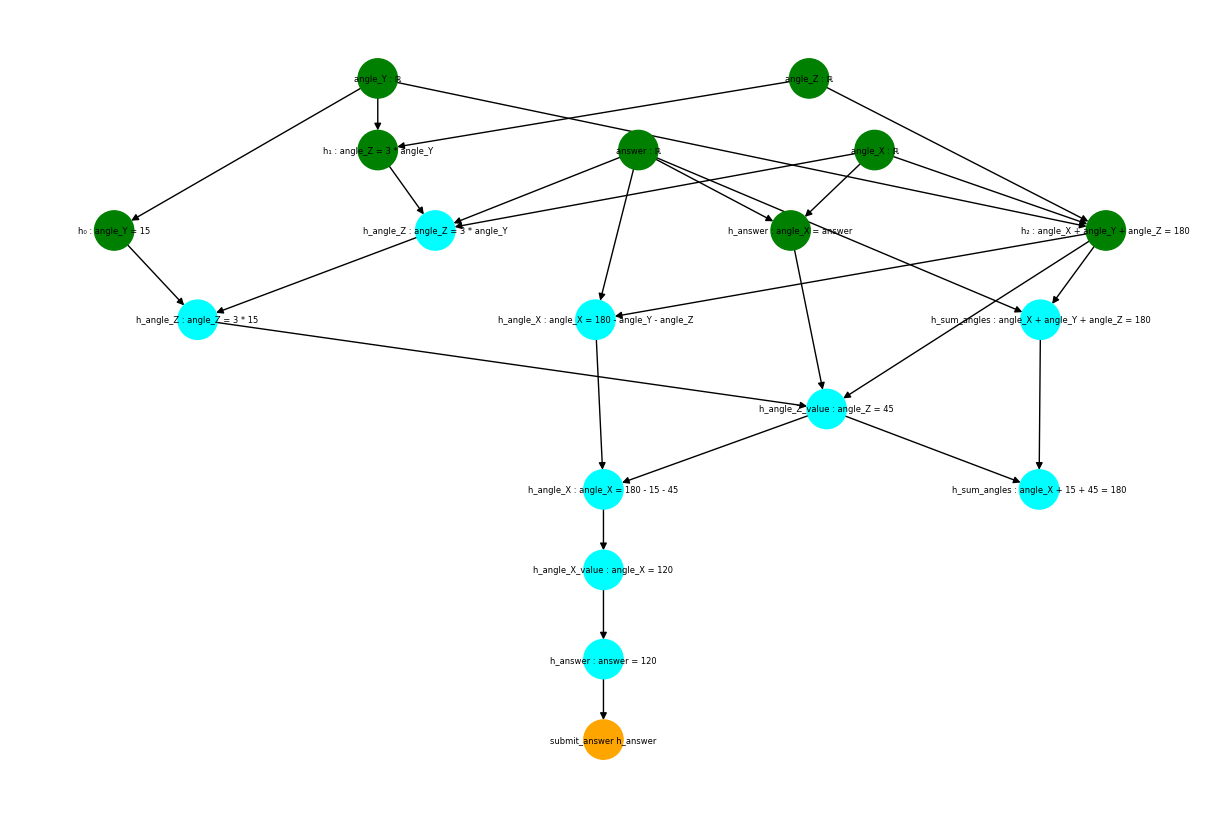

In [32]:
reduced_dependency_graph = nx.algorithms.dag.transitive_reduction(dependency_graph)

pos = nx.nx_agraph.graphviz_layout(reduced_dependency_graph, prog="dot", args="")
plt.figure(figsize=(12, 8))

# pos = nx.bfs_layout(dependency_graph, parsed_steps[0])
# pos = forest_bfs_layout(dependency_graph, [node for node, in_degree in dependency_graph.in_degree() if in_degree == 0])

color_map = ['orange' if node.is_submitting else 'cyan' if node.is_deducing else 'green' for node in reduced_dependency_graph.nodes]
# edge_styles = [
#     ('--' if e not in hard_dependencies_global else '-') for e in reduced_dependency_graph.edges
# ]

labels = {node: '\n'.join(str(v) for v in (node.new_contexts or [node.step])) for node in reduced_dependency_graph}

nx.draw(reduced_dependency_graph, pos, with_labels=True, labels=labels, node_size=800, font_size=6, node_color=color_map)
plt.show()

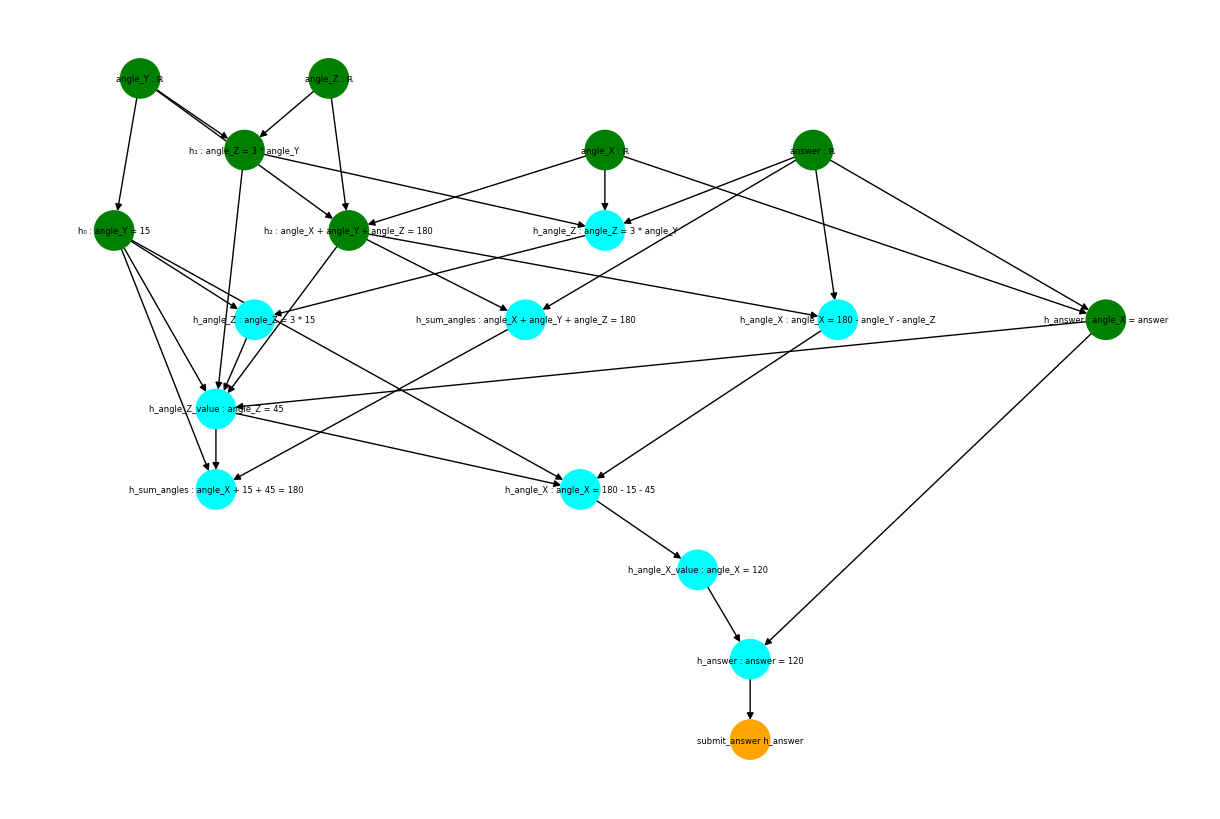

In [33]:
#* For visualization only
direct_dependency_graph = nx.algorithms.dag.transitive_reduction(dependency_graph)
direct_dependency_graph.add_edges_from(hard_dependencies_global) # Add this -> direct dependency graph

pos = nx.nx_agraph.graphviz_layout(direct_dependency_graph, prog="dot", args="")
plt.figure(figsize=(12, 8))

# pos = nx.bfs_layout(dependency_graph, parsed_steps[0])
# pos = forest_bfs_layout(dependency_graph, [node for node, in_degree in dependency_graph.in_degree() if in_degree == 0])

color_map = ['orange' if node.is_submitting else 'cyan' if node.is_deducing else 'green' for node in reduced_dependency_graph.nodes]
# edge_styles = [
#     ('--' if e not in hard_dependencies_global else '-') for e in reduced_dependency_graph.edges
# ]

labels = {node: '\n'.join(str(v) for v in (node.new_contexts or [node.step])) for node in direct_dependency_graph}

nx.draw(direct_dependency_graph, pos, with_labels=True, labels=labels, node_size=800, font_size=6, node_color=color_map)
plt.show()

## Exploratory Action Sequence Reassembling

In [34]:
depth_dict = {n : 0 for n in parsed_steps}

In [35]:
for u in nx.topological_sort(reduced_dependency_graph):
    for v in reduced_dependency_graph.successors(u):
        depth_dict[v] = max(depth_dict[v], depth_dict[u]+1)

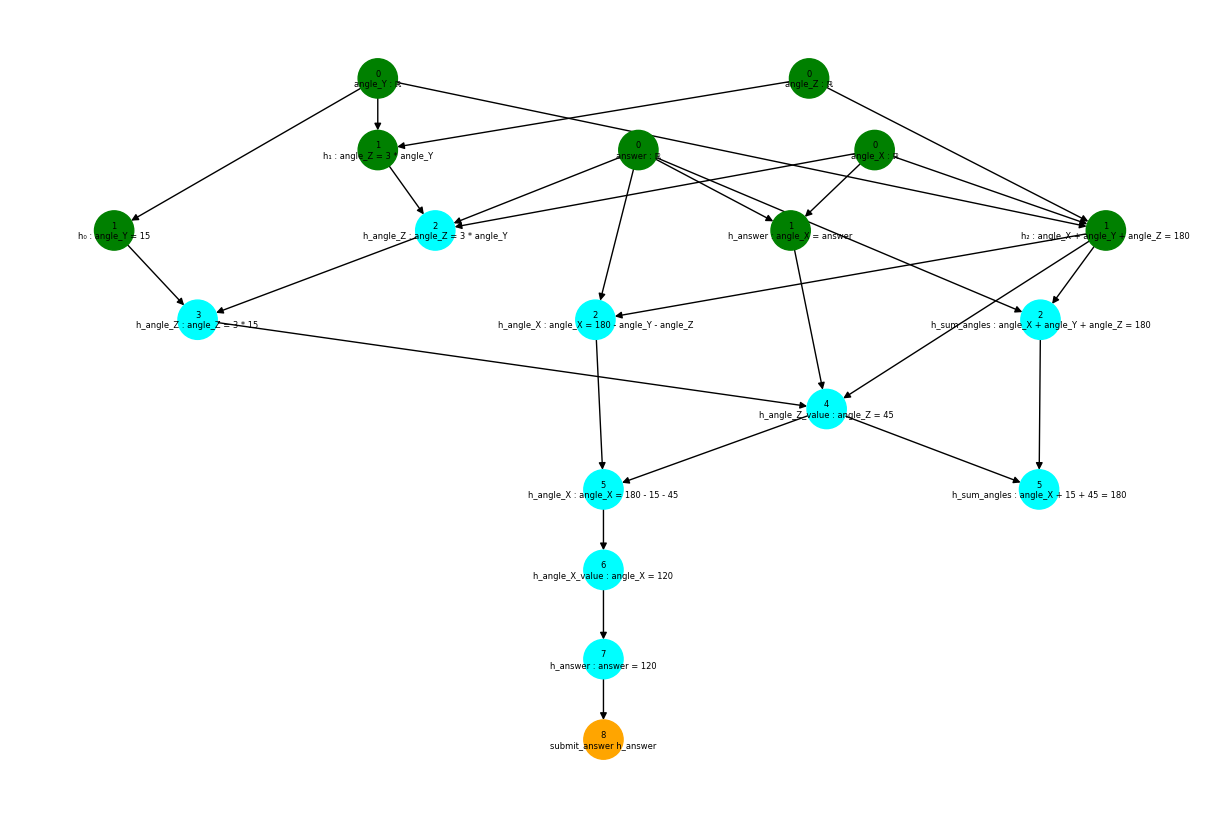

In [38]:
pos = nx.nx_agraph.graphviz_layout(reduced_dependency_graph, prog="dot", args="")
plt.figure(figsize=(12, 8))


color_map = ['orange' if node.is_submitting else 'cyan' if node.is_deducing else 'green' for node in reduced_dependency_graph.nodes]

labels = {n: str(depth_dict[n]) + '\n' + '\n'.join(str(v) for v in (n.new_contexts or [n.step])) for n in reduced_dependency_graph.nodes}

nx.draw(reduced_dependency_graph, pos, with_labels=True, labels=labels, node_size=800, font_size=6, node_color=color_map)
plt.show()

In [44]:
reassembled_trajectory = []
G = reduced_dependency_graph.copy()
deductive_state = await server.tactic_server.load_statement_async('False')

while True:
    available_actions = sorted([n for (n, d) in G.in_degree() if d == 0], key=lambda n : (-depth_dict[n], n.is_introducing))
    chosen_action = available_actions[0]
    reassembled_trajectory.append((deductive_state.goals[0].variables, chosen_action))
    if chosen_action.is_submitting:
        assert submission_name in [v.name for v in deductive_state.goals[0].variables]
        if not set(deductive_state.goals[0].variables).issubset(set(forward_state.goals[0].variables)):
            logger.warning(f'¬(deductive_state ⊆ forward_state): {deductive_state.goals[0].variables}, {forward_state.goals[0].variables}')
        break
    deductive_state = await server.tactic_server.goal_tactic_async(deductive_state, 0, chosen_action.step)
    G.remove_node(chosen_action)

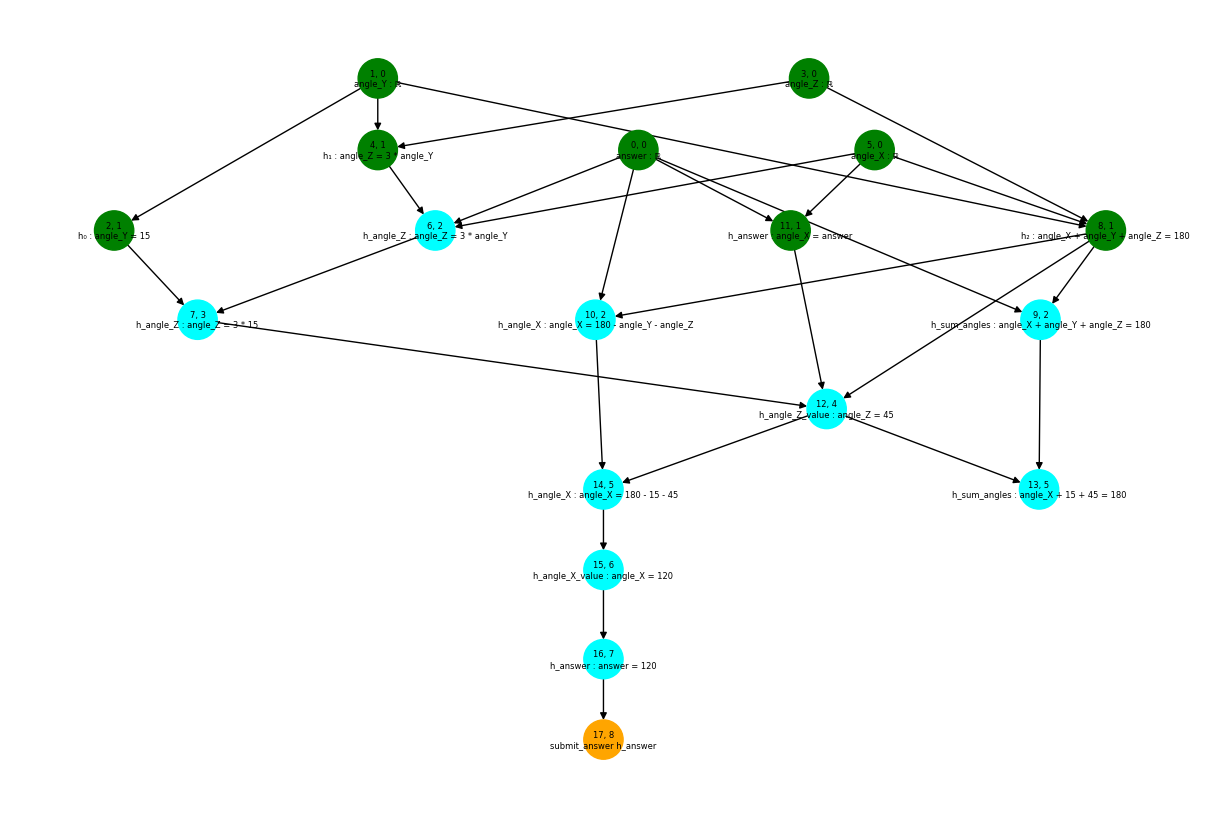

In [45]:
pos = nx.nx_agraph.graphviz_layout(reduced_dependency_graph, prog="dot", args="")
plt.figure(figsize=(12, 8))


color_map = ['orange' if node.is_submitting else 'cyan' if node.is_deducing else 'green' for node in reduced_dependency_graph.nodes]

order_dict = {
    n : i for i, (s, n) in enumerate(reassembled_trajectory)
}
labels = {n: f'{order_dict[n]}, {depth_dict[n]}' + '\n' + '\n'.join(str(v) for v in (n.new_contexts or [n.step])) for n in reduced_dependency_graph.nodes}

nx.draw(reduced_dependency_graph, pos, with_labels=True, labels=labels, node_size=800, font_size=6, node_color=color_map)
plt.show()